# Sharpe Ratioを目的関数とした予測・執行モデル
## はじめに
### 予測と執行
株・為替・仮想通貨などの自動取引を試みたことがある人なら，**予測**と**執行**の問題[1]に直面したことがあるのではないか．**予測の問題**とは将来のリターンを予測する問題であり，**執行の問題**とは（予測の情報をもとに）どのように注文を出すのかという問題である．ただ，どのような戦略を取るかで予測・執行それぞれの問題の扱い方は変わる．以下は戦略の例である．
- HFTやアービトラージ
    - 筆者は全く詳しくないが，ほとんど執行方法が重要になるそうだ．
- シストレ
    - 例えば5分移動平均線が20分移動平均線とクロスしたら買い（もしくは売り）のような売買のシグナルを探す戦略である．これは一見，予測ではなく執行を問題にしているように思えるが，もしある有効なシグナルがあった場合，そのシグナルが本当に有効ならば，そのシグナルの強さと将来のリターンは相関するはずである．つまり，執行問題と予測問題を同時に解いているとも言える．
- 機械学習による予測
    - これには様々な問題設定があり得るが，単純に将来のリターンを予測する場合を考える．この時，新しい情報が得られる度（例えば10分毎）に予測をし，毎回注文を出していると執行コストがかさんでしまう．これを回避するには，次の3つの方法が考えられる．
        1. 予測の精度を極限まで高める．
        2. 執行コストが問題にならないほど長い時間軸で予測モデルを作る．
        3. 執行方法を工夫する．
    - 今回は3.執行方法を工夫する方法を考える．

今回はこの予測と執行という独立でない2つの問題を別々に解く方法を考える．そのために，**予測モデル**と**執行モデル**を別々に作り，学習させた．
### 予測モデルの問題設定
リターンを予測するモデルを作る中で，次のような課題に直面した．

##### 1. リターンの統計的性質が悪い．
株価のリターンは正規分布にはならず，裾の重い分布になることが知られている．これは予測モデルを作る際の一つの障壁になる．
##### 2. 目的関数・予測精度・パフォーマンスの不一致．
取引のパフォーマンスを評価する際，次のSharpe Ratioが最もよく使われる．
$$
Sharpe Ratio = \frac{mean(r)}{std(r)}
$$
ただし，$r$は各地点におけるリターン．次の図は，Sharpe Ratioと累積リターンのプロットである．

<img src="./pictures/sr0.png">

機械学習で予測モデルを作る際，次のような流れになることが多い．  
MSEを目的関数としてモデルを訓練→実際のリターンと予測値の間の相関係数が高くなることを確認→Sharpe Ratioでパフォーマンスを評価．  
しかし，「MSEが低い→相関係数が高い→Sharpe Ratioが高い」は成り立たない．
- 「MSEが低い→相関係数が高い」  
    株価リターンのように0が中心のノイズが多いデータでMSEを目的関数として訓練すると，0に近い値ばかりを出力するように訓練されることがある．訓練を通して確かにMSEは低くなるが，相関係数は低くならない．
- 「相関係数が高い→Sharpe Ratioが高い」  
    「$x$とその予測値$y$について，ある特定の$x$の区間においてのみ$x$と$y$が一致する」ような場合でも相関係数が高くなることがある．相関係数はこのようなアーチファクトに弱い．  

以上のことから，次のようなモデルを作りたいと考えた．
- リターンを直接予測しないモデル
- 最初からSharpe Ratioを目的関数として訓練するモデル

### 執行モデルの問題設定
執行モデルは予測モデルの出力を含む現在の状態$\boldsymbol{s}$から，最適な次のポジション$\{Sell, Hold, Buy\}$を返す関数として機能する．これはモデル予測制御[2]（MPC; Model Predictive Control）と同様の考え方である．今回は予測モデルと同様にSharpe Ratioを目的関数とする決定木ベースのモデルを作った．

## 方法
### データセット
- Bybit APIから出来高の多い上位50の通貨の1分足データを取得（2023年10月の1カ月分）．  
- OHLCV(Open/High/Low/Close/Volume)のうち，Close（終値）のみを使用．

### 前処理（DataMaker）
#### 特徴量
- 残差リターンの抽出
    - その通貨の値動きは様々なファクターを用いて説明することができる．その通貨の値動きのうち，諸々のファクターによっては説明され得ない「その通貨独自の値動き」を残差リターンという．
    - 今回，残差リターンは[3]を参考に，PCAによって求めた．
    - その通貨の$\{3, 5, 10, 15, 20, 25, 30, 40, 50, 60, 75, 90\}$分間の残差リターンを特徴量とした．

#### ターゲット
- それぞれの通貨の$\{5, 10, 15\}$分後の生のリターンをターゲットとした．

### 予測モデル（DecisionTreePredictor）
#### アルゴリズム
- 予測モデルは$d$次元の特徴量ベクトル$\boldsymbol{x}$に対して，$\{-1, 0, 1\}$のlabelを返す．
- 予測モデルは次のような決定木の構造を持つ．

<img src="./pictures/tree0.png">

- 決定木の葉ノードにはlabelが置かれる．$\{-1, 0, 1\}$のlabelはそれぞれ$\{Sell, Hold, Buy\}$を意味し，訓練期間におけるSharpe Ratioが高くなるように訓練される．
- 決定木の葉以外のノードには，以下のような条件式が置かれる．条件式は[4]を参考にした．

$$
O(\boldsymbol{x}[a], \boldsymbol{x}[b]) > T
$$
ただし，
$$
O(\boldsymbol{x}[a], \boldsymbol{x}[b]) = 
    \begin{cases}
        \boldsymbol{x}[a] + \boldsymbol{x}[b]\\
        \boldsymbol{x}[a] - \boldsymbol{x}[b]\\
        \boldsymbol{x}[a] * \boldsymbol{x}[b]\\
        \boldsymbol{x}[a]\\
        \boldsymbol{x}[b]\\
        max(\boldsymbol{x}[a], \boldsymbol{x}[b])\\
        min(\boldsymbol{x}[a], \boldsymbol{x}[b])\\
    \end{cases}
$$
- また，閾値$T$は，$O(\boldsymbol{x}[a], \boldsymbol{x}[b])$の分位点に基づいて決定される．

予測モデルの訓練は以下のアルゴリズムによって行われる．
- 訓練の停止条件
    - 全ての葉ノードにおいて，以下のいずれかが成り立っている．
        1. 指定した深さまで到達している．
        2. 木のSharpe Ratioをそれ以上高くする条件式が見つからない．
- 訓練時，予測モデルは上の停止条件に達するまで，以下を繰り返す．
    1. 葉ノードをランダムに選ぶ．
    2. 特徴量のペア$a, b$をランダムに選ぶ．
    3. Sharpe Ratioが最も高くなるような条件式$O(\boldsymbol{x}[a], \boldsymbol{x}[b]) > T$を求める．
    4.
       - 元の木と比較してSharpe Ratioが高くなった場合: 選択した葉ノードに条件式を当てはめる．（1に戻るか訓練が完了する）
       - 元の木と比較してSharpe Ratioが高くならない場合: 特徴量のペア$a, b$を選び直す．（2に戻る）
       - 全ての特徴量のペア$a, b$において，Sharpe Ratioが元の木を上回らない場合: その葉ノードは成長を止める．（1に戻るか訓練が完了する）

### 予測モデルのアンサンブル
予測モデルの訓練方法にはランダム性があるため，1つのデータセットから複数のモデルを作りアンサンブル（予測値の集約）することができる．
モデルのアンサンブルには次の3つの意味がある．
1. モデルのバリアンスが下がり，予測値の信頼性が増す．
2. それぞれのモデルの予測値は$\{-1, 0, 1\}$のいずれかであるが，それらを平均することで$[-1, 1]$の間の連続値にすることができる．これは，$\{Sell, Hold, Buy\}$への分類問題を，$[-1, 1]$への回帰問題に帰着させていることになる．
4. モデルの予測値の標準偏差$std(model_{1}(\boldsymbol{x}), .., model_{n}(\boldsymbol{x}))$は予測値の確信度を表す．つまり，予測値のばらつきが大きい場合，予測に対する確信度が小さく（予測値はあまり信頼できない），ばらつきが小さい場合，確信度が大きい（予測値は比較的信頼できる）と言える．これは，分位点回帰やベイズモデルにおける予測分布の標準偏差に相当する．

### 執行モデル（DecisionTreeAgent）
#### アルゴリズム
- 執行モデルは現在の状態$\boldsymbol{s}$から次の地点における最適なポジション$\{-1, 0, 1\}$を返す関数として機能する．状態$\boldsymbol{s}$は次のように与える．
    - $\boldsymbol{s}[0]$ : 現在のポジション$\{-1, 0, 1\}$
    - $\boldsymbol{s}[1]$ : 現在のポジションの長さ
    - $\boldsymbol{s}[2]$ : 現在の累積リターン
    - $\boldsymbol{s}[3]$ : 5分後のリターンの予測値$[-1, 1]$
    - $\boldsymbol{s}[4]$ : 上の予測の確信度（予測値の標準偏差）
    - $\boldsymbol{s}[5]$ : 10分後のリターンの予測値$[-1, 1]$
    - $\boldsymbol{s}[6]$ : 上の予測の確信度（予測値の標準偏差）
    - $\boldsymbol{s}[7]$ : 15分後のリターンの予測値$[-1, 1]$
    - $\boldsymbol{s}[8]$ : 上の予測の確信度（予測値の標準偏差）
- 予測モデルと同様に，決定木ベースのモデルを用いて，訓練期間のSharpe Ratioを最大化するように訓練される．

## 実験
本来Juliaのスクリプトは関数の中で実行しなければならない（トップレベルに書くと実行速度が非常に遅くなるため）が，今回は説明のためにトップレベルに書いた．
### パッケージの読込み

In [1]:
include("../src/DataMaker.jl")
include("../src/DecisionTreePredictor.jl")
include("../src/DecisionTreeAgent.jl")

using Main.DataMaker: make_data
using Main.DecisionTreePredictor: construct_predictor_tree, predict_labels, construct_ensemble_tree, predict_ensemble_tree
using Main.DecisionTreeAgent: construct_agent_tree, predict_positions

using CSV: File
using DataFrames
using Statistics
using Plots
using ProgressMeter
using Base: summarysize
using Mmap: mmap
using Base.Threads

# メモリマップのための関数の定義
function create_mmap(X, path)
    s = open(path, "w+")
    n_dims = Int64(ndims(X))
    write(s, n_dims)
    for i in 1:n_dims
        sz = Int64(size(X, i))
        write(s, sz)
    end
    write(s, X)
    close(s)
end

function fetch_mmap(path, type_)
    s = open(path, "r")
    n_dims = read(s, Int64)
    v = zeros(Int, n_dims)
    for i in 1:n_dims
        v[i] = read(s, Int64)
    end
    offset = 8 * (n_dims + 1)  
    close(s)  
    X = mmap(path, type_, Tuple(v), offset)  
    return X
end

fetch_mmap (generic function with 1 method)

### データの読込み

出来高の多い上位60通貨の1分足データを読込む．

In [2]:
file = "../data/data_bybit.csv"
data = File(file) |> DataFrame
select!(data, Not(1))
data_matrix = Matrix(data)
symbols = names(data)
n_symbols = 60
symbols = symbols[1:n_symbols]
data_matrix = data_matrix[:, 1:n_symbols]

data = nothing
GC.gc()
println("data_matrix : ", size(data_matrix))

data_matrix : (43200, 60)


### 前処理
`DataMaker.make_data`を使用して，それぞれの通貨の残差リターンを計算する．  
`make_data`は残差リターンに加えて，各時刻の生のリターンとターゲットも返す．

In [3]:
k_list = [3, 5, 10, 15, 20, 25, 30, 40, 50, 60, 75, 90] 
t_list = [5, 10, 15]
len_t_list = length(t_list)
test_size = 2880
raw_returns_train, train_features, train_targets, raw_returns_test, test_features, test_targets = make_data(
    data=data_matrix, t_list=t_list, k_list=k_list, test_size=test_size, pc_param=0.2
)

# メモリマップを作成
dir = "../data"
raw_returns_train_path = joinpath(dir, "raw_returns_train.bin")
train_features_path = joinpath(dir, "train_features.bin")
train_targets_path = joinpath(dir, "train_targets.bin")

create_mmap(raw_returns_train, raw_returns_train_path)
create_mmap(train_features, train_features_path)
create_mmap(train_targets, train_targets_path)

raw_returns_train_type = typeof(raw_returns_train)
train_features_type = typeof(train_features)
train_targets_type = typeof(train_targets)

raw_returns_train = nothing
train_features = nothing
train_targets = nothing
GC.gc()

raw_returns_train = fetch_mmap(raw_returns_train_path, raw_returns_train_type)
train_features = fetch_mmap(train_features_path, train_features_type)
train_targets = fetch_mmap(train_targets_path, train_targets_type)

println(
    "raw_returns_train : ", size(raw_returns_train), "\n",
    "train_features : ", size(train_features), "\n",
    "train_targets : ", size(train_targets), "\n",
    "raw_returns_test : ", size(raw_returns_test), "\n",
    "test_features : ", size(test_features), "\n",
    "test_targets : ", size(test_targets)
)

raw_returns_train : (60, 40215)
train_features : (60, 40215, 12)
train_targets : (60, 3, 40215)
raw_returns_test : (60, 2880)
test_features : (60, 2880, 12)
test_targets : (60, 3, 2880)


訓練期間が40215分（約28日），テスト期間が2880分（2日）のデータセットが完成した．

### 予測モデル
#### 訓練
`DecisionTreePredictor.construct_ensemble_tree`は指定した深さの決定木を指定した個数生成する．  
今回は60通貨それぞれに対して，木の深さ2のモデルを40個作る．  
訓練によって得られた決定木のrootノードは`predictor_root_list`に格納される．

In [ ]:
ensemble_params = Dict(
    2 => 40
)
predictor_root_list = Any[nothing for i in 1:n_symbols]

@showprogress for coin_ind in 1:n_symbols
    train_features_coin = @view train_features[coin_ind, :, :]
    root_list_coin = []
    
    for t_ind in 1:len_t_list
        train_targets_coin_t = @view train_targets[coin_ind, t_ind, :]
        root_list = construct_ensemble_tree(
            ensemble_params=ensemble_params, features=train_features_coin, 
            targets=train_targets_coin_t, min_samples=40, n_thresholds=7
        )
        
        push!(root_list_coin, root_list)
    end
    
    GC.gc()
    predictor_root_list[coin_ind] = root_list_coin
end

#### テスト
`DecisionTreePredictor.predict_ensemble_tree`は`predictor_root_list`と特徴量を用いて，予測値の平均`labels_mean`と標準偏差`labels_std`を返す．  
訓練データに対する予測値を求めているのは，執行モデルの訓練に使うためである．

In [ ]:
n_samples_train = size(train_features)[2]
labels_mean_train = zeros(Float64, n_symbols, len_t_list, n_samples_train)
labels_std_train = zeros(Float64, n_symbols, len_t_list, n_samples_train)

n_samples_test =  size(test_features)[2]
labels_mean_test = zeros(Float64, n_symbols, len_t_list, n_samples_test)
labels_std_test = zeros(Float64, n_symbols, len_t_list, n_samples_test)

@showprogress for coin_ind in 1:n_symbols
    train_features_coin = @view train_features[coin_ind, :, :]
    test_features_coin = @view test_features[coin_ind, :, :]
    
    for t_ind in 1:len_t_list
        root_list = predictor_root_list[coin_ind][t_ind]

        labels_mean, labels_std = predict_ensemble_tree(
            root_list=root_list, features=train_features_coin, return_labels=false
        )
        labels_mean_train[coin_ind, t_ind, :] = labels_mean
        labels_std_train[coin_ind, t_ind, :] = labels_std

        labels_mean, labels_std = predict_ensemble_tree(
            root_list=root_list, features=test_features_coin, return_labels=false
        )
        labels_mean_test[coin_ind, t_ind, :] = labels_mean
        labels_std_test[coin_ind, t_ind, :] = labels_std
    end
end

# 予測精度（相関係数）の計算
acc_list1 = zeros(Float64, n_symbols, len_t_list)
for i in 1:n_symbols
    for j in 1:len_t_list
        acc_list1[i, j] = cor(labels_mean_test[i, j, :], test_targets[i, j, :])
    end
end

acc_list2 = zeros(Float64, n_symbols, len_t_list)
for i in 1:n_symbols
    for j in 1:len_t_list
        mask = labels_std_test[i, j, :] .< mean(labels_std_test[i, j, :])
        acc_list2[i, j] = cor(labels_mean_test[i, j, :] .* mask, test_targets[i, j, :] .* mask)
    end
end

#### 予測精度
ターゲット（$\{5, 10, 15\}$分先のリターン）ごとに，全通貨の予測精度（ターゲットと予測値の間の相関係数）のヒストグラムを描画した．  
なお，予測精度の平均値を赤線で示した．

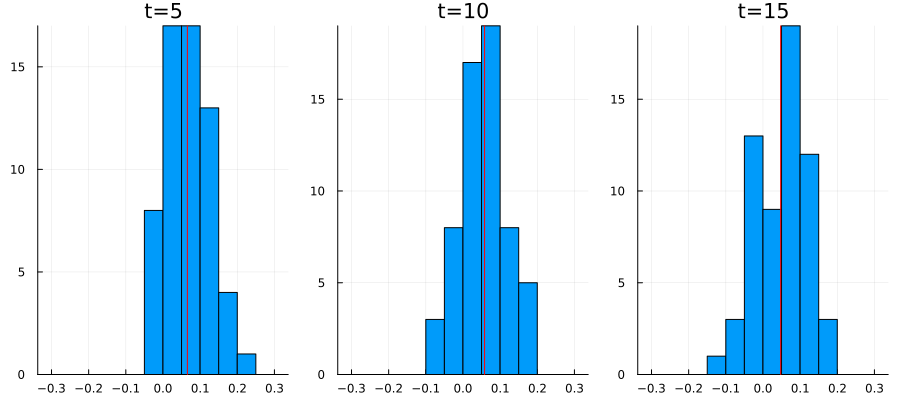

In [6]:
b_range = range(-0.3, 0.3, length=13)
p1 = histogram(acc_list1[:, 1], title="t=5", bins=b_range)
vline!([mean(acc_list1[:, 1])], color=:red)
p2 = histogram(acc_list1[:, 2], title="t=10", bins=b_range)
vline!([mean(acc_list1[:, 2])], color=:red)
p3 = histogram(acc_list1[:, 3], title="t=15", bins=b_range)
vline!([mean(acc_list1[:, 3])], color=:red)
plot(p1, p2, p3, layout=(1, 3), size=(900, 400), legend=false)

#### 標準偏差の効果
予測値の標準偏差が平均未満の場合において，上と同様にターゲットと予測値の間の相関係数を求めた．  
予測値の標準偏差を限定しない場合と比較して精度が向上していることから，モデルの予測に対する確信度(標準偏差)はある程度信頼できることがわかる．

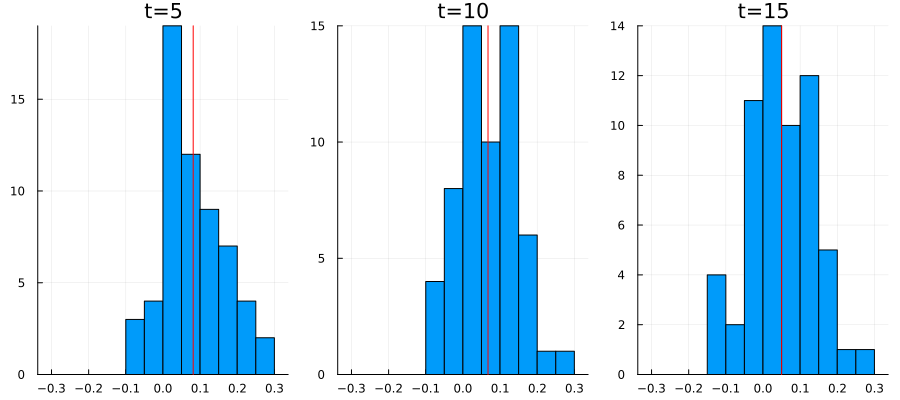

In [7]:
b_range = range(-0.3, 0.3, length=13)
p1 = histogram(acc_list2[:, 1], title="t=5", bins=b_range)
vline!([mean(acc_list2[:, 1])], color=:red)
p2 = histogram(acc_list2[:, 2], title="t=10", bins=b_range)
vline!([mean(acc_list2[:, 2])], color=:red)
p3 = histogram(acc_list2[:, 3], title="t=15", bins=b_range)
vline!([mean(acc_list2[:, 3])], color=:red)
plot(p1, p2, p3, layout=(1, 3), size=(900, 400), legend=false)

### 執行モデル
#### 訓練・テスト
`DecisionTreeAgent.construct_agent_tree`は訓練期間における予測値の平均と標準偏差を特徴量として決定木モデルを構築する．  
`DecisionTreeAgent.predict_positions`は訓練によって得られた決定木`agent_root`と特徴量をもとに予測を行う．  
また，往復で0.04%の取引手数料を課した．

In [ ]:
fee = 0.0004
acc_list_train = zeros(Float64, n_symbols)
returns_all = zeros(Float64, n_symbols, n_samples_test)

@showprogress for coin_ind in 1:n_symbols
    agent_features_train = hcat(labels_mean_train[coin_ind, :, :]', labels_std_train[coin_ind, :, :]')
    agent_root, best_score = construct_agent_tree(
        raw_returns=raw_returns_train[coin_ind, :], features=agent_features_train,
        fee=fee, max_depth=3, n_thresholds=5, 
        cum_return_thresholds=Float64[0],
        position_len_thresholds=Float64[0, 2, 4, 6, 8, 10], return_score=true
    )
    acc_list_train[coin_ind] = best_score

    if agent_root.right === nothing
        nothing
    else
        agent_features_test = hcat(labels_mean_test[coin_ind, :, :]', labels_std_test[coin_ind, :, :]')
        positions_test = predict_positions(agent_root, agent_features_test, raw_returns_test[coin_ind, :], fee)
        returns_all[coin_ind, :] = positions_test[:, 4]
    end
end

全60通貨のうち，訓練期間でSharpe Ratioが最も高い$k$通貨を選んでトレードすると，テスト期間において次のようなパフォーマンスが得られる．

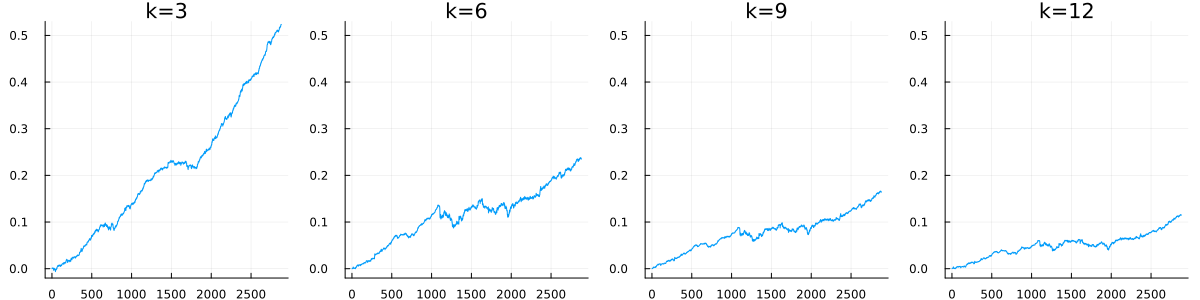

In [34]:
indices = sortperm(acc_list_train, rev=true)
indices_k = indices[1:3]
returns_mean = vec(mean(returns_all[indices_k, :], dims=1))
p1 = plot(cumprod(returns_mean .+ 1) .- 1, legend=false, title="k=3", ylim=(-0.02, 0.53))
indices_k = indices[1:6]
returns_mean = vec(mean(returns_all[indices_k, :], dims=1))
p2 = plot(cumprod(returns_mean .+ 1) .- 1, legend=false, title="k=6", ylim=(-0.02, 0.53))
indices_k = indices[1:9]
returns_mean = vec(mean(returns_all[indices_k, :], dims=1))
p3 = plot(cumprod(returns_mean .+ 1) .- 1, legend=false, title="k=9", ylim=(-0.02, 0.53))
indices_k = indices[1:12]
returns_mean = vec(mean(returns_all[indices_k, :], dims=1))
p4 = plot(cumprod(returns_mean .+ 1) .- 1, legend=false, title="k=12", ylim=(-0.02, 0.53))
plot(p1, p2, p3, p4, layout=(1, 4), size=(1200, 300), legend=false)

縦軸は累積リターン．横軸は分．テスト期間は2日（2880分）である．

## 結論
### 結果について
上のグラフを見ると，2日で50%もの利益を上げられるように見えるが，実際はスプレッドを考慮するとほとんど利益にならない．また，上の実験において安定的に収益が出る通貨ほどスプレッドが大きいことがわかった．このことから，実際の取引において手数料やスプレッドに吸収されて消えてしまうリターンはおおよそ簡単に予測できるとも言える．

### 課題
- 今回作ったモデルをより強力な特徴量を用いて訓練することで，執行コストに負けないモデルにできる可能性はある．強力な特徴量を見つけるために，生のデータから特徴量を自動的に探索・生成する手法を開発したいと考えている．
- OHLCVのような誰でも簡単に手に入れられるデータだけでは，強力な特徴量を作るのは難しい．オンチェーンデータのような，ファンダメンタルズの情報を含んだデータを使うことも考えている．

## 参照
[1] 予測力と執行戦略について｜Hoheto (仮想通貨botter). (2022, 1月 16). note（ノート）. https://note.com/hht/n/nb7fcfe538c59  
[2] モデル予測制御入門 1：モデル予測制御の考え方. (2023, 11月 14). Zenn. https://zenn.dev/takuya_fukatsu/articles/439dd7d6163abf  
[3] Imajo, K., Minami, K., Ito, K., & Nakagawa, K. (2021). Deep Portfolio Optimization via Distributional Prediction of Residual Factors. Proceedings of the AAAI Conference on Artificial Intelligence, 35(1), Article 1. https://doi.org/10.1609/aaai.v35i1.16095  
[4] Ito, K., Minami, K., Imajo, K., & Nakagawa, K. (2020). Trader-Company Method: A Metaheuristic for Interpretable Stock Price Prediction (arXiv:2012.10215). arXiv. https://doi.org/10.48550/arXiv.2012.10215
